# Lecture 2: Supervised Learning

In this lab, you will learn to decode hand position from neural activity in the primate primary motor cortex (M1) using GLMs and random fores

In [1]:
import numpy as np
import scipy.io
import sklearn

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)

colors=['#F5A21E', '#02A68E', '#EF3E34', '#134B64', '#FF07CD','b']

# Data
Below we load a dataset available on CRCNS: a [Macaque M1](http://crcns.org/data-sets/movements/dream/downloading-dream) (from [Stevenston et al. 2011](http://jn.physiology.org/content/106/2/764.short)).

The data has been organized in Matlab into neat arrays for easy loading here.

We will soon want a single numpy array representing the external covariates, and a single numpy vector representing the neural response. The data array X will be of dimensions (n, p), where n is the number of time bins and p is the number of covariates, and the response y will be of dimensions (n, ).

#### Load data

In [2]:
m1 = scipy.io.loadmat('data/m1_stevenson_2011.mat')
m1['time'] = m1['time'].squeeze()
m1['sampling_rate'] = 1/np.diff(m1['time']).mean()

### Plot raw M1 data

This gives some intuitive feeling for the type of data we're working with.

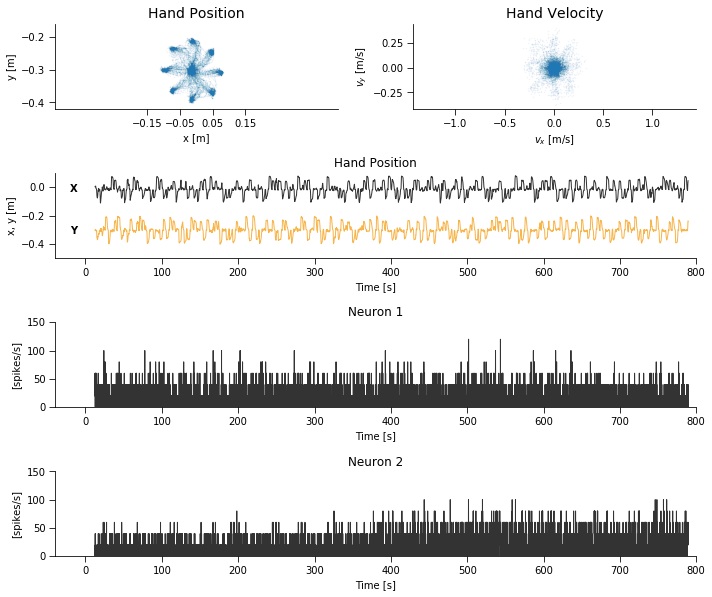

In [3]:
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'medium'

# Position scatter
ts = 14
gs0 = gridspec.GridSpec(5, 2)
plt.subplot(gs0[0,0])
simpleaxis(plt.gca())
plt.scatter(m1['handPos'][0,:], m1['handPos'][1,:], s=.1, alpha=.1)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.title('Hand Position',fontsize=ts)
plt.ylim([-0.42,-0.16])
plt.xlim([-0.15,0.15])
plt.xticks(np.arange(-0.15,0.2, .1))

# Velocity scatter
plt.subplot(gs0[0,1])
simpleaxis(plt.gca())
plt.scatter(m1['handVel'][0,:], m1['handVel'][1,:], s=.1, alpha=.1)

plt.xlabel('$v_x$ [m/s]')
plt.ylabel('$v_y$ [m/s]')
plt.axis('equal')
plt.title('Hand Velocity',fontsize=ts)

# Position trace
plt.subplot(gs0[1,:])
a=plt.gca()
simpleaxis(a)
a.text(-20,-.03,'X',weight='bold')
a.text(-20,-.33,'Y',weight='bold')
alpha = 0.8
lw = 1
plt.plot(m1['time'], m1['handPos'][0,:], 'k-', alpha=alpha, lw=lw)
plt.plot(m1['time'], m1['handPos'][1,:], '-', color=colors[0], alpha=alpha, lw=lw)
a.axis([-40,800,-0.5,0.1])

plt.xlabel('Time [s]')
plt.ylabel('x, y [m]')
plt.title('Hand Position')


# Neuron 1 firing rate
plt.subplot(gs0[2,:])
a=plt.gca()
simpleaxis(a)
alpha = 0.8
lw = 1
plt.plot(m1['time'], m1['sampling_rate']*m1['spikes'][0,:], 'k-', alpha=alpha, lw=lw)
a.axis([-40,800,0.0,150])

plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.title('Neuron 1')

# Neuron 1 firing rate
plt.subplot(gs0[3,:])
a=plt.gca()
simpleaxis(a)
alpha = 0.8
lw = 1
plt.plot(m1['time'], m1['sampling_rate']*m1['spikes'][1,:], 'k-', alpha=alpha, lw=lw)
a.axis([-40,800,0.0,150])

plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.title('Neuron 2')


plt.tight_layout()
plt.show()

## Exercise 1: Decode hand position from neural activity using a linear decoder
### Hints:

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import medfilt

def plot_positions(t, Y_test, Y_predict):
    """Plots true and predicted hand positions over time"""
    plt.figure(figsize=(15,10))
    a=plt.gca()
    simpleaxis(a)
    a.text(np.min(t)-20,-.03,'X',weight='bold')
    a.text(np.min(t)-20,-.33,'Y',weight='bold')
    alpha = 0.9
    lw = 1
    plt.plot(t_test, medfilt(Y_predict.T[0,:], 5), 'c-', t_test, Y_test.T[0,:], 'm-', alpha=alpha, lw=lw)
    plt.plot(t_test, medfilt(Y_predict.T[1,:], 5), 'c-', t_test, Y_test.T[1,:], 'm-', alpha=alpha, lw=lw)
    plt.legend(['pred', 'true'])
    plt.xlabel('Time [s]')
    plt.ylabel('x, y [m]')
    plt.title('Hand Position')
    plt.show()
    
def mean_absolute_percentage_error(Y_test, Y_predict):
    return float(np.mean(np.abs((Y_test - Y_predict)/Y_predict)))

def score_positions(Y_test, Y_predict):
    """Scores given hand positions using standard metrics"""
    return (mean_squared_error(Y_test, Y_predict),
            mean_absolute_error(Y_test, Y_predict),
            r2_score(Y_test, Y_predict),
            mean_absolute_percentage_error(Y_test, Y_predict))

In [5]:
def print_score(scores):
    metrics = "MSE", "MAE", "COD", "MAPE"
    list(map(print, metrics, scores))

$$
y = w^T x + b
$$

MSE 0.0010061659115427348
MAE 0.025424473173018092
COD 0.494643643738311
MAPE 5.949951561829979


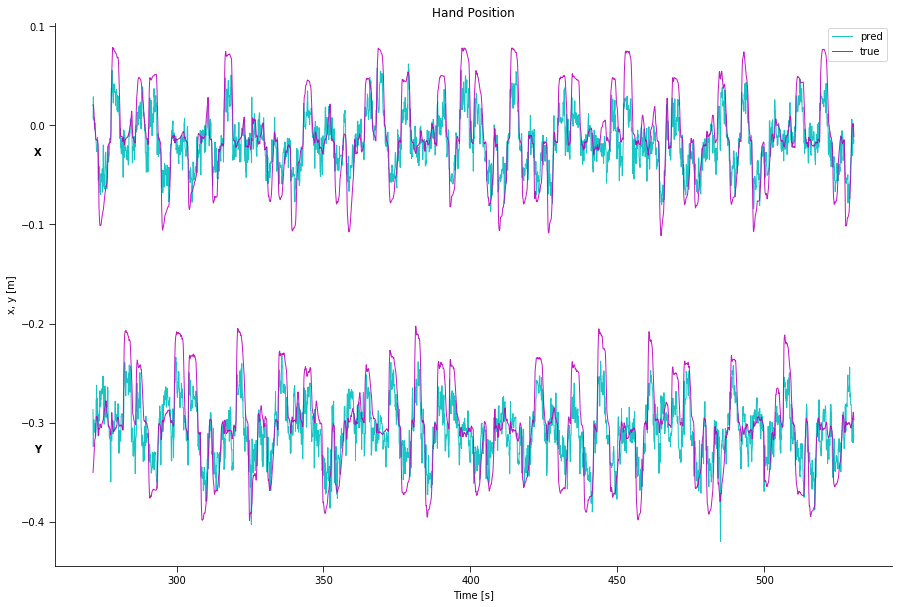

MSE 0.0010570320645445523
MAE 0.02537209252928519
COD 0.4740456569508477
MAPE 15.271983756355182


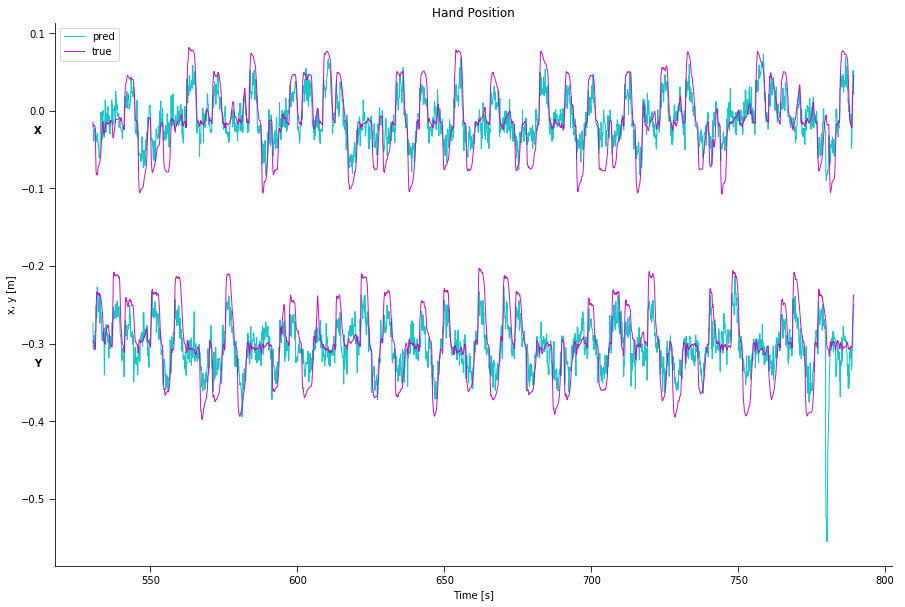

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model

# load data (X is neural activity, Y is hand position response)
Y = m1['handPos'].T[:,0:2]
X = m1['spikes'].T
t = m1['time']

# Generate 5 different splits of your data into train and test data sets for cross validation
tscv = TimeSeriesSplit(n_splits=2)

# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index], t[test_index]
    
    """
    Fit your linear regression model here, extract relevant metrics and plot test performance.
    """
    model = linear_model.LinearRegression(normalize=True)
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_test)
    print_score(score_positions(Y_test, Y_predict))
    plot_positions(t_test, Y_test, Y_predict)

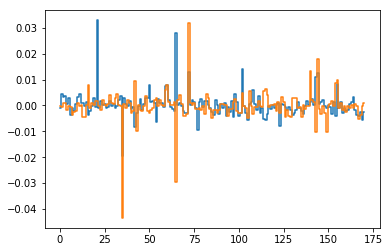

In [7]:
plt.plot(model.coef_.T, linestyle="steps-mid")

In [8]:
np.argsort(abs(model.coef_))[:, -10:]


array([[155,  42,  77, 143, 144,  72, 102,  35,  65,  21],
       [ 42,  43, 155, 143, 149, 140, 144,  65,  72,  35]])

In [9]:
abs(model.coef_[0]).argsort()

array([ 66,  14,  68, 117,  32, 121,  73, 150,  24, 125,  83,  88, 119,
       148,  38, 103, 139,  44,  29, 137, 142,  18,  80,   9, 109,  20,
        27,  30, 162, 124, 151,   4,  41, 126, 128, 145,  25,  37, 106,
        47,  62,  94,  58,  90,  56,  91,  12, 149, 156,  26,  57,   0,
       159, 134,  13,  53,  92,  22,  67, 120,  84,  31,  76, 122, 133,
       113,  99,   7, 157,  78, 107, 140,  15, 153, 163, 146,  75,  51,
        40, 118,  63,  23,  82,  52, 129,  39, 110,  96, 127,  28, 132,
        81, 138,  46, 165, 161,  87,   8,  61, 147,  64,  17, 160,  33,
        74,  69, 135,  55, 170,  79,  45, 141,  85,  95, 168, 101,  43,
       104, 131,  48,  36,  71,   5,  19,  70, 112, 158,  49, 116, 164,
        89,  10, 152,   2, 136,   3, 166, 111,   6,  86,  34,  16, 130,
       167, 100,  93, 154,  11,   1,  97,  98, 114, 105, 115, 169, 108,
        54,  59, 123,  50,  60, 155,  42,  77, 143, 144,  72, 102,  35,
        65,  21])

## Exercise 2: Find the 10 best neurons for decoding hand position
### Hints:

MSE 0.0019873885095850466
MAE 0.03287836401088495
COD -0.0003493721717516829
MAPE 1.3168966085113816


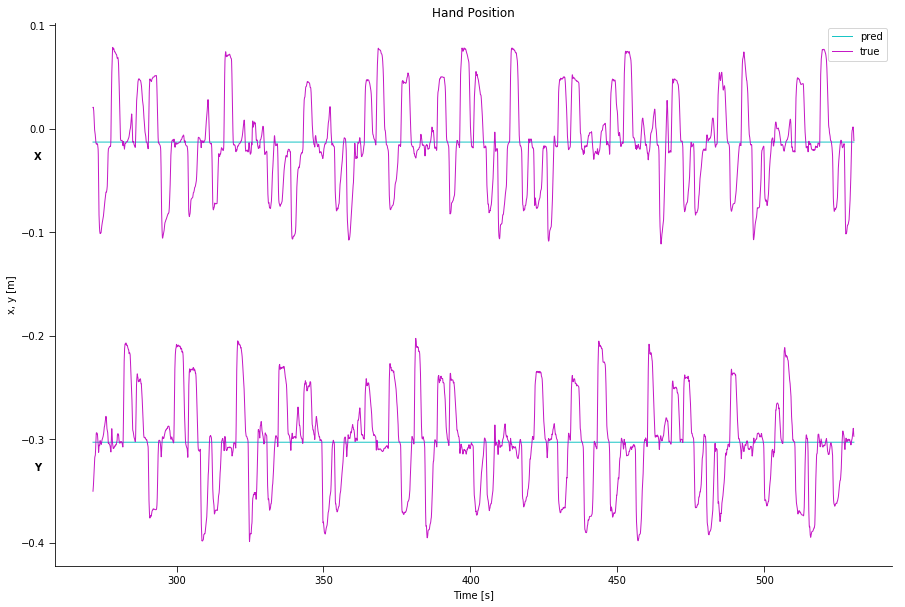

MSE 0.0020068575979107347
MAE 0.032961762400534056
COD -0.002707311914927568
MAPE 1.357896997063492


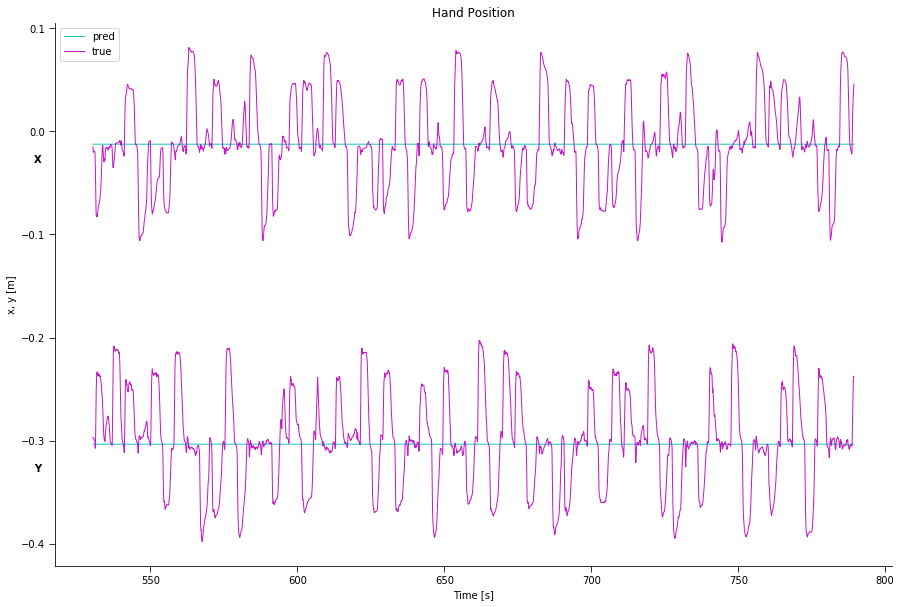

In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model

# load data (X is neural activity, Y is hand position response)
Y = m1['handPos'].T[:,0:2]
X = m1['spikes'].T
t = m1['time']

# Generate 5 different splits of your data into train and test data sets for cross validation
tscv = TimeSeriesSplit(n_splits=2)

# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index], t[test_index]
    
    """
    Fit your linear regression model with L1 regularization (lasso) here, 
    extract relevant metrics and plot test performance.
    """
#     model = linear_model.MultiTaskLassoCV(n_jobs=-1)
    model = linear_model.Lasso(alpha=1, selection="random", tol=1e-10)
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_test)
    print_score(score_positions(Y_test, Y_predict))
    plot_positions(t_test, Y_test, Y_predict)

## Exercise 3: Build the best possible nonlinear decoder
### Hints:

In [13]:
import tpot

In [14]:
Y_train.shape

(5180, 2)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import ensemble

# load data (X is neural activity, Y is hand position response)
Y = m1['handPos'].T[:,0:2]
X = m1['spikes'].T
t = m1['time']

# Generate 5 different splits of your data into train and test data sets
tscv = TimeSeriesSplit(n_splits=2)

# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index], t[test_index]
    
    """
    Experiment and find/implement the best performing non-linear model here, 
    start with a Random Forest Classifier and compare your results to the linear models, iterate.
    Extract relevant metrics and plot test performance.
    """
    models = [tpot.TPOTRegressor() for i in range(Y_train.shape[1])]
    Y_predict = []
    for Y_train_sub, model in zip(Y_train.T, models):
        %time model.fit(X_train, Y_train_sub)
        Y_predict.append(model.predict(X_test))
    Y_predict = np.asarray(Y_predict)
    print_score(score_positions(Y_test, Y_predict))
    plot_positions(t_test, Y_test, Y_predict)
    break

## Exercise 4: Build an encoding model for neuron 0 to predict neural activity from hand position and velocity using a linear-nonlinear-Poisson GLM

Use `statsmodels`

Install using `pip install statsmodels`

### Hints:

In [11]:
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [12]:
# function to convert cartesian coordinates to radial coordinates
def convert_2_angular_coord(Y):
    radius = np.sqrt(Y[:,0]**2+Y[:,1]**2).reshape([-1,1])
    radius = radius
    angle = np.angle(Y[:,0]+Y[:,1]*1j, deg=False).reshape([-1,1])
    angle = np.cos(angle)
    return radius, angle

# create meshgrid to plot tuninng curves
def create_dummy_xy_coordinates(Y_centered):
    ''' return augmented dummy Y - Tx [1, x_coord, y_coord]'''
    ymax = Y_centered.max(axis = 0).max()
    ymin = Y_centered.min(axis = 0).min()
    x_coord = np.arange(ymin, ymax, 0.01)
    y_coord = np.arange(ymin, ymax, 0.01)
    xx_cart_coord, yy_cart_coord = np.meshgrid(x_coord, y_coord)
    return xx_cart_coord, yy_cart_coord

def augment_data(Y):
    return np.hstack([np.ones([Y.shape[0],1]),Y]) 

In [13]:
# center data
Y_centered = Y-Y.mean(axis = 0)
# don't forget to add a bias term
Y_cart = augment_data(Y_centered)

# convert to radial coordinate
radius, angle = convert_2_angular_coord(Y)
# don't forget to add a bias term
Y_rad = augment_data(np.hstack([radius, angle]))

# combine both?
Y_comb = np.hstack([Y_cart, radius, angle])


In [14]:
# select your favourite neurons
best_neurons = [0, 2, 141, 32, 111, 50, 59, 48, 16, 98, 154]

In [15]:
# generate dummy hand coordinates in both cartesian and radial coordinates
# for cartesian coordinates
xx_cart_coord, yy_cart_coord  = create_dummy_xy_coordinates(Y_centered)
Y_cart_dummy = augment_data(np.vstack([ xx_cart_coord.flatten(), yy_cart_coord.flatten()]).T )   

# repeat for radial coordinates
radius_dummy, angle_dummy = convert_2_angular_coord(Y_cart_dummy[:,1:3])
Y_rad_dummy = augment_data(np.hstack([radius_dummy, angle_dummy]))

# repeat for both (or add your favourite features)
Y_comb_dummy = np.hstack([Y_cart_dummy, radius_dummy, angle_dummy])

In [12]:
def run_model(neuron_num, X, Y_cart, Y_cart_dummy, xx_cart):
    ## split data
    ## create a model
    ## fit model
    ## predict firing rate on dummy grid
    return poisson_model, results, rate_pred, data

In [13]:
poisson_model_cart, results_cart, rate_pred_cart, data_cart = \
run_model(best_neurons[0], X, Y_cart, Y_cart_dummy, xx_cart_coord)

poisson_model_radial, results_radial, rate_pred_radial, data_radial = \
run_model(best_neurons[0], X, Y_rad, Y_rad_dummy, xx_cart_coord)

poisson_model_comb, results_comb, rate_pred_comb, data_comb = \
run_model(best_neurons[0], X, Y_comb, Y_comb_dummy, xx_cart_coord)

In [14]:
print(results_cart.summary())
print(results_radial.summary())
print(results_comb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10409
Model:                            GLM   Df Residuals:                    10406
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10311.
Date:                Tue, 18 Sep 2018   Deviance:                       11025.
Time:                        13:34:31   Pearson chi2:                 1.09e+04
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5835      0.013    -44.424      0.000      -0.609      -0.558
x1            -0.7235      0.307     -2.360      0.0

In [15]:
def plot_predictions(rate_pred_cart,rate_pred_radial,rate_pred_comb, xx_cart_coord, title):
    fig = plt.figure(figsize = (21,10))
    extent = [xx_cart_coord[0,0],xx_cart_coord[-1,-1], xx_cart_coord[0,0],xx_cart_coord[-1,-1]] 
    fig.add_subplot(1,3,1)
    plt.imshow(rate_pred_cart, extent = extent)
    plt.title('predicted firing rate with \ncartesian basis', fontsize = 23)
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')

    fig.add_subplot(1,3,2)
    plt.imshow(rate_pred_radial, extent = extent)
    plt.title('predicted firing rate with \nradial basis', fontsize = 23)
    plt.yticks([])
    plt.xlabel('x coordinate')

    fig.add_subplot(1,3,3)
    plt.imshow(rate_pred_comb, extent = extent)
    plt.title('predicted firing rate with \nboth feature vector', fontsize = 23)

    plt.yticks([])
    plt.xlabel('x coordinate')
    plt.suptitle(title)
    # plt.ylabel('y coordinate')
    plt.tight_layout()

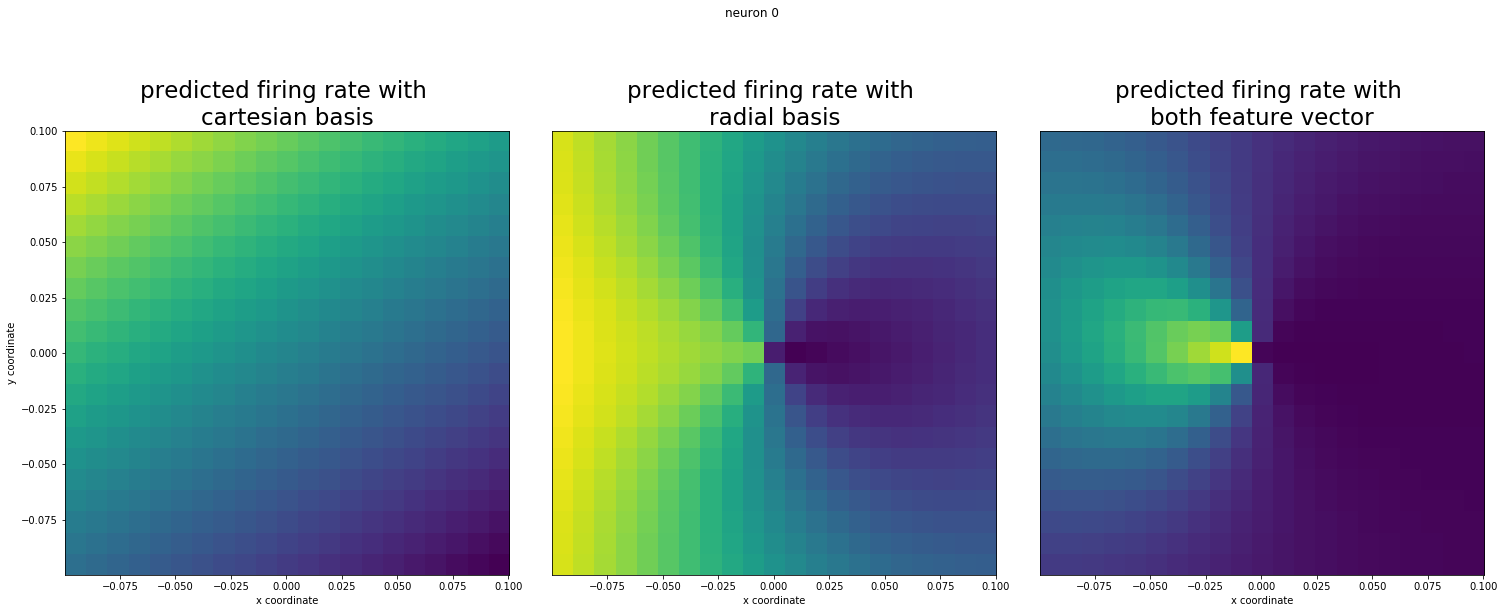

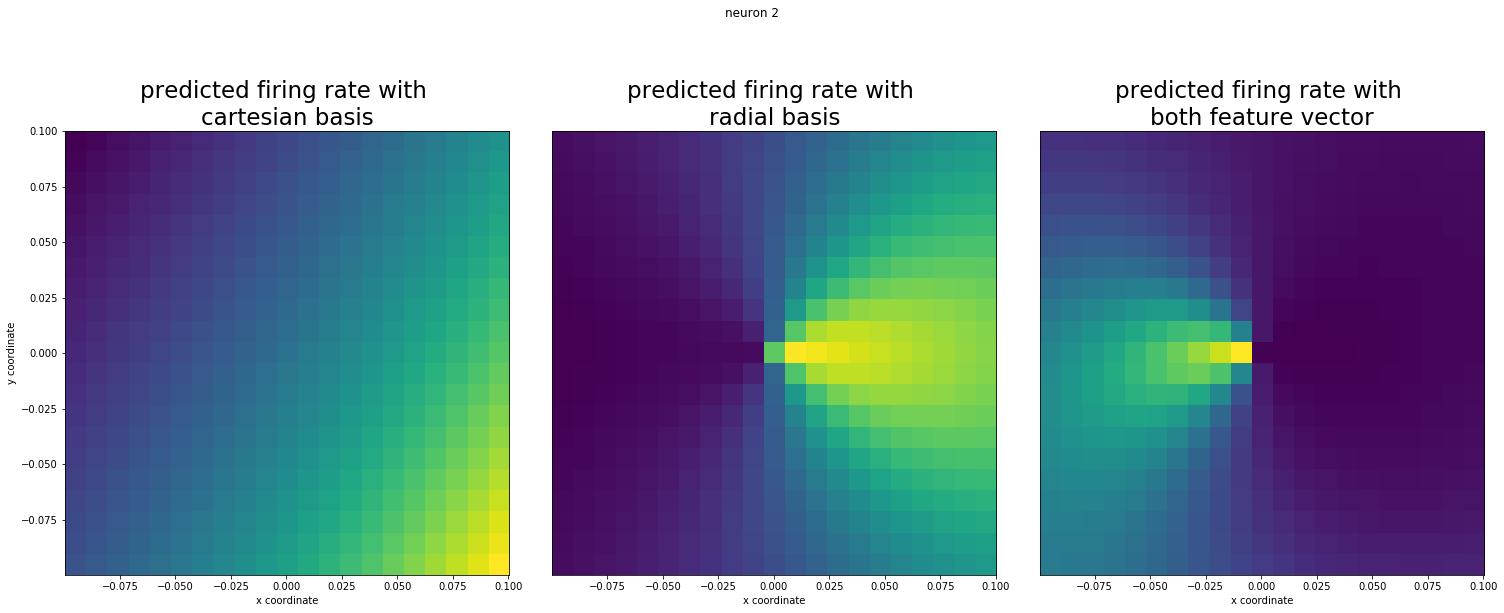

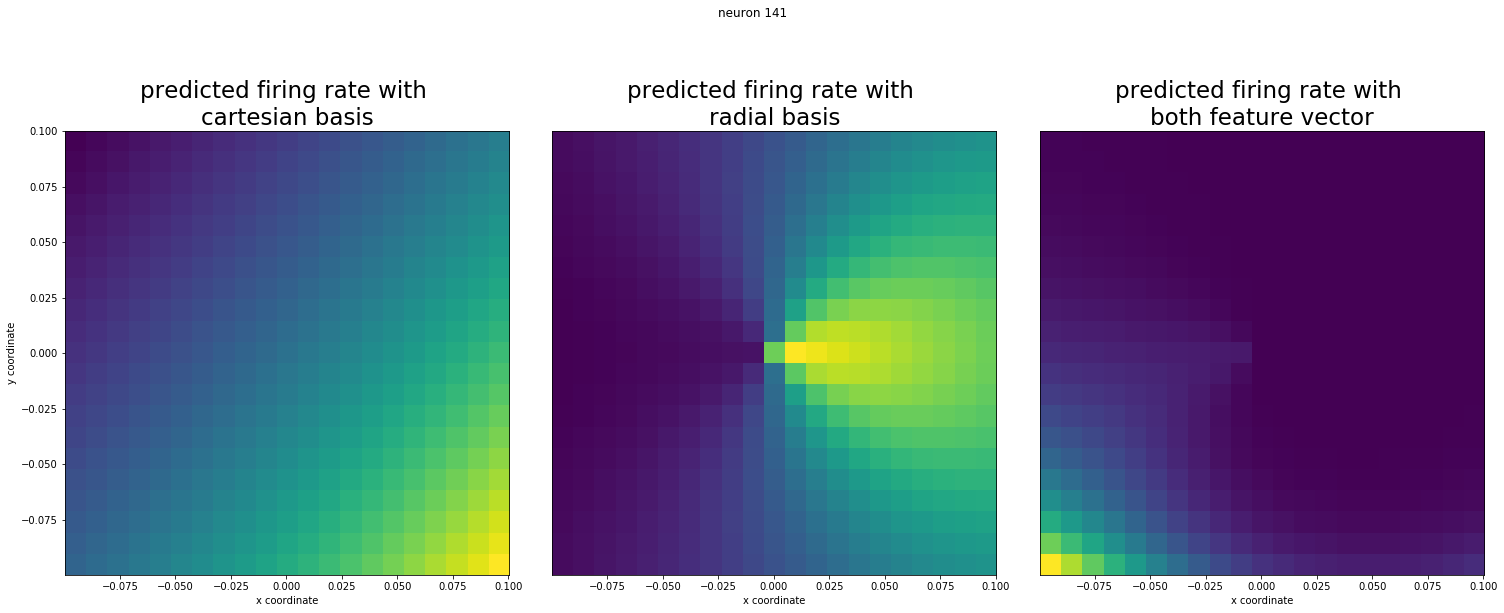

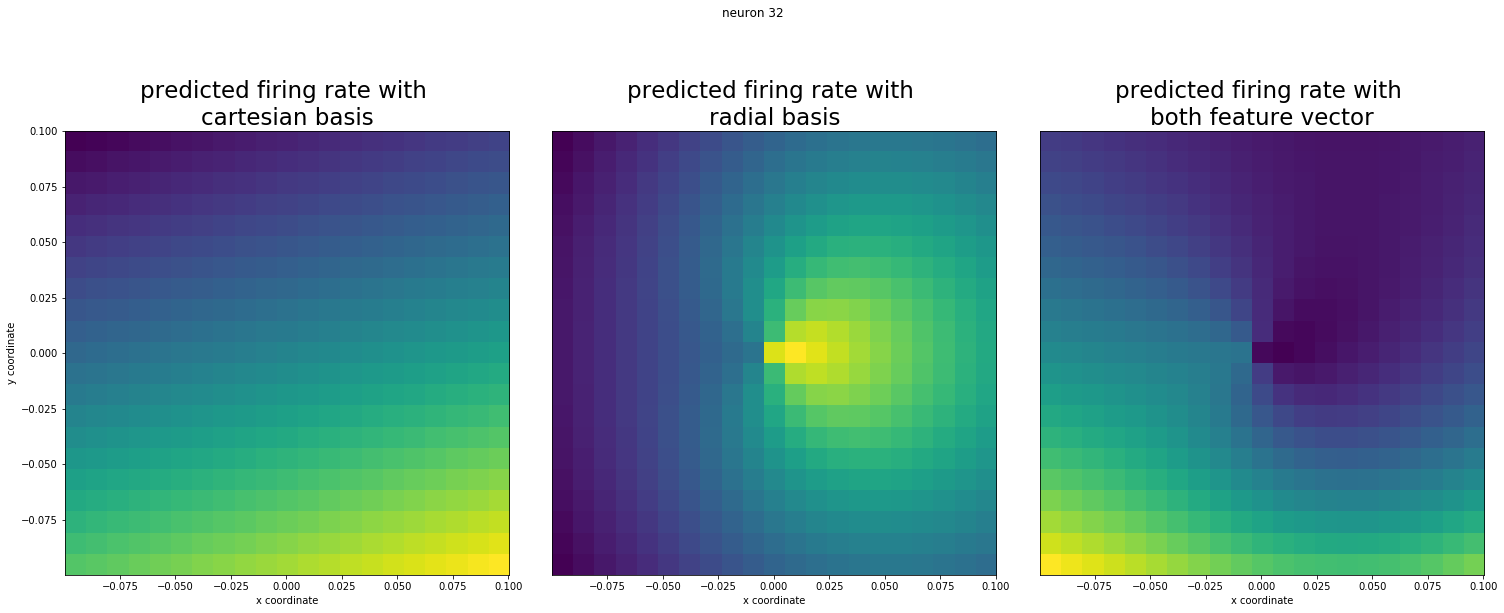

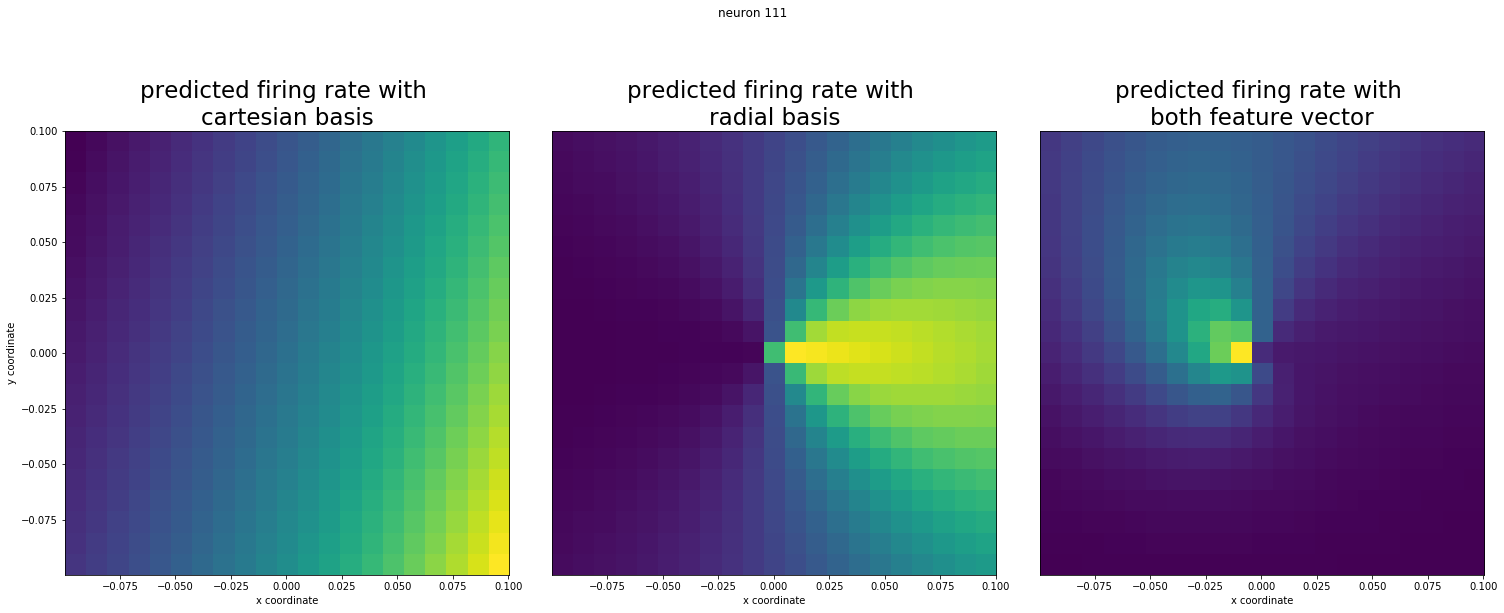

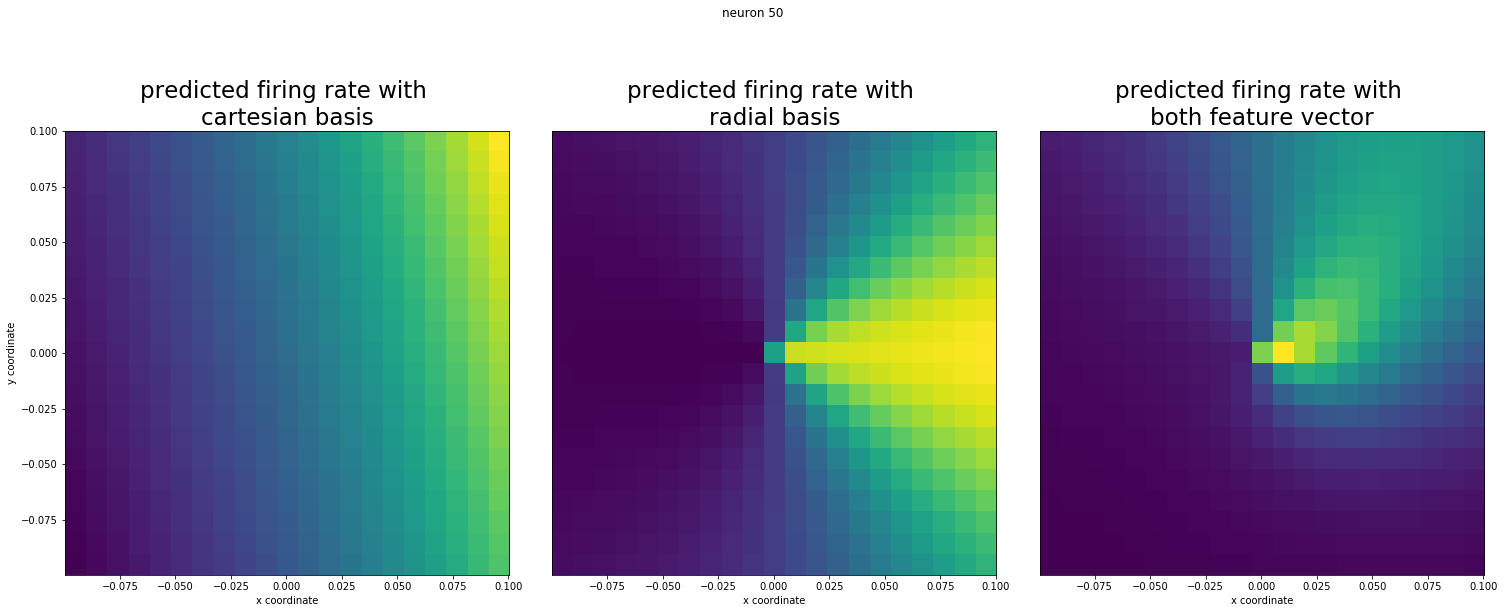

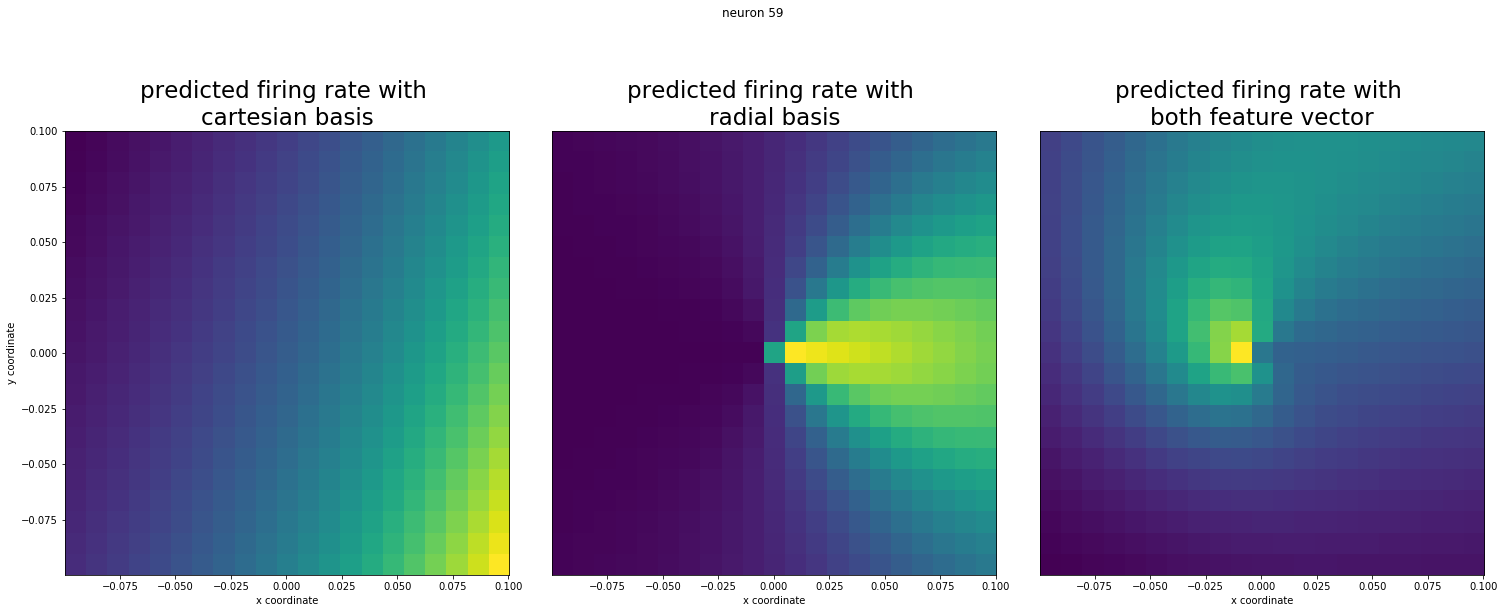

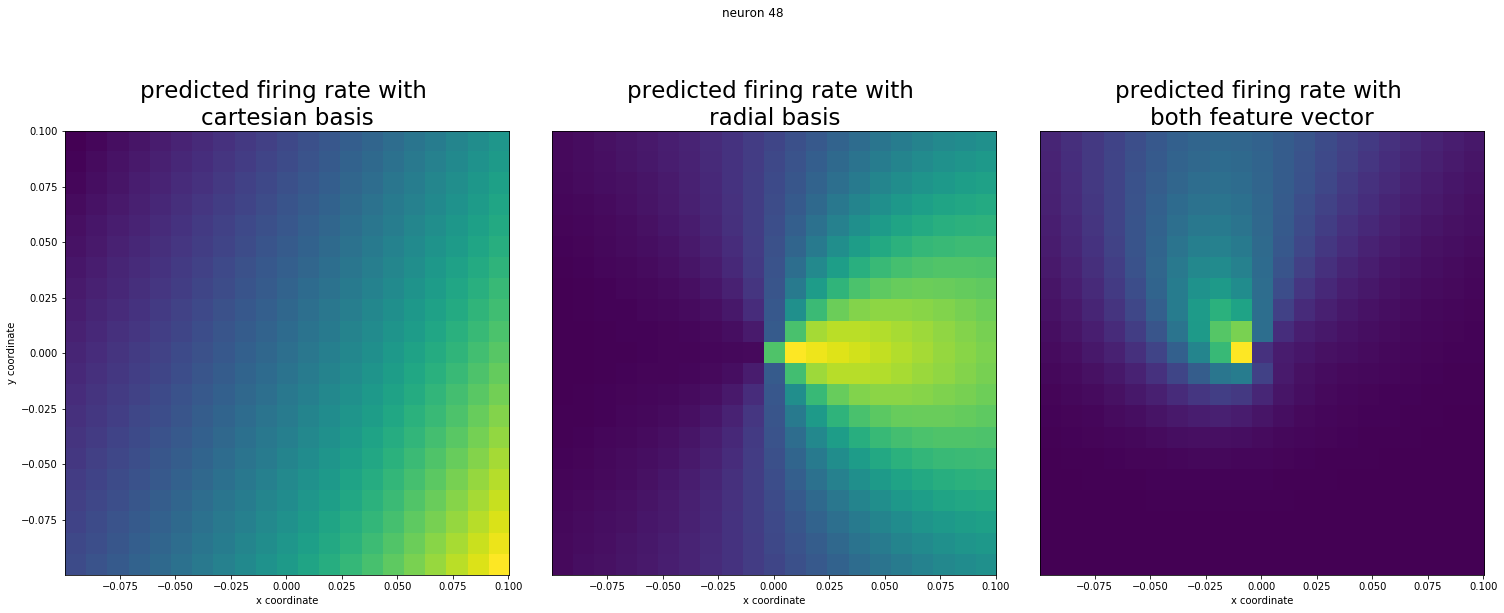

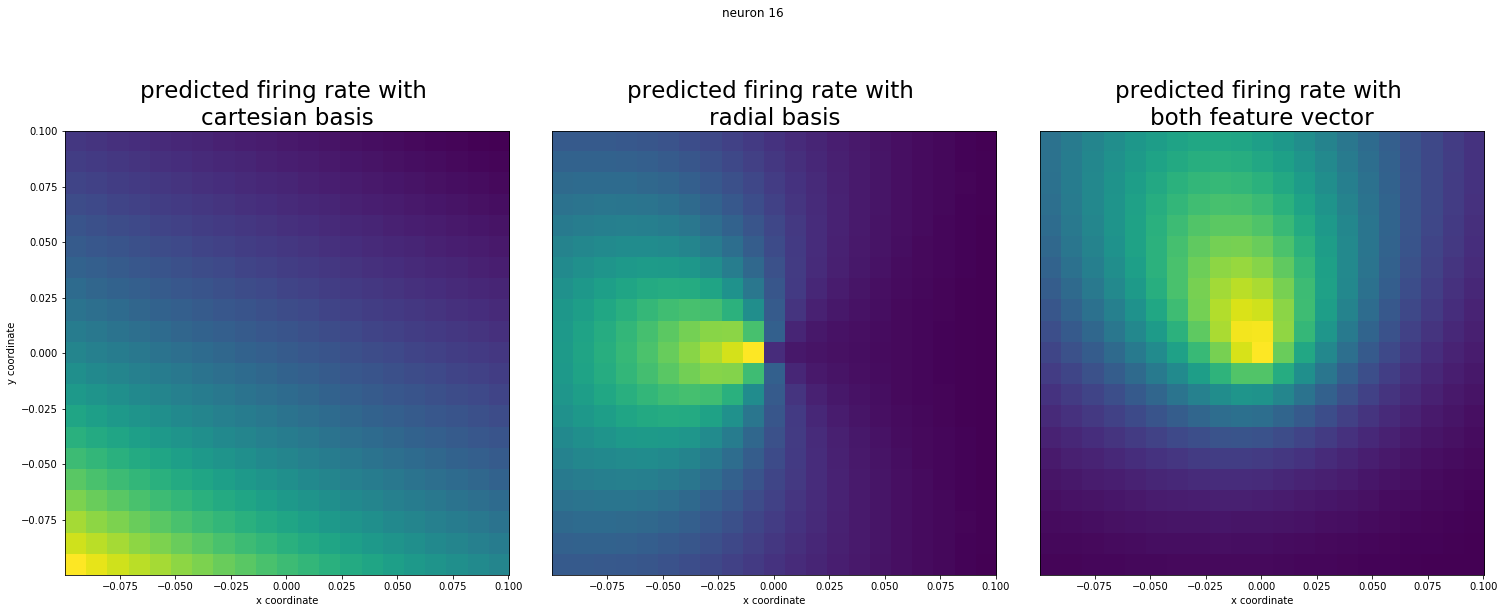

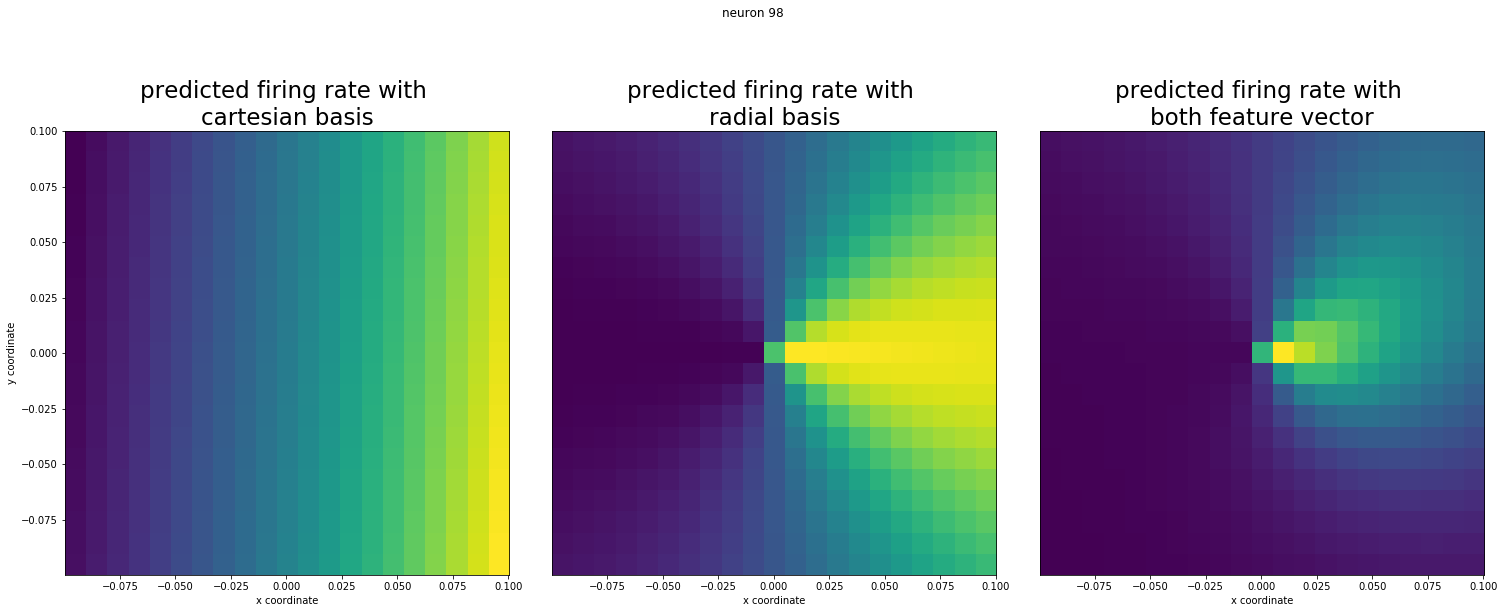

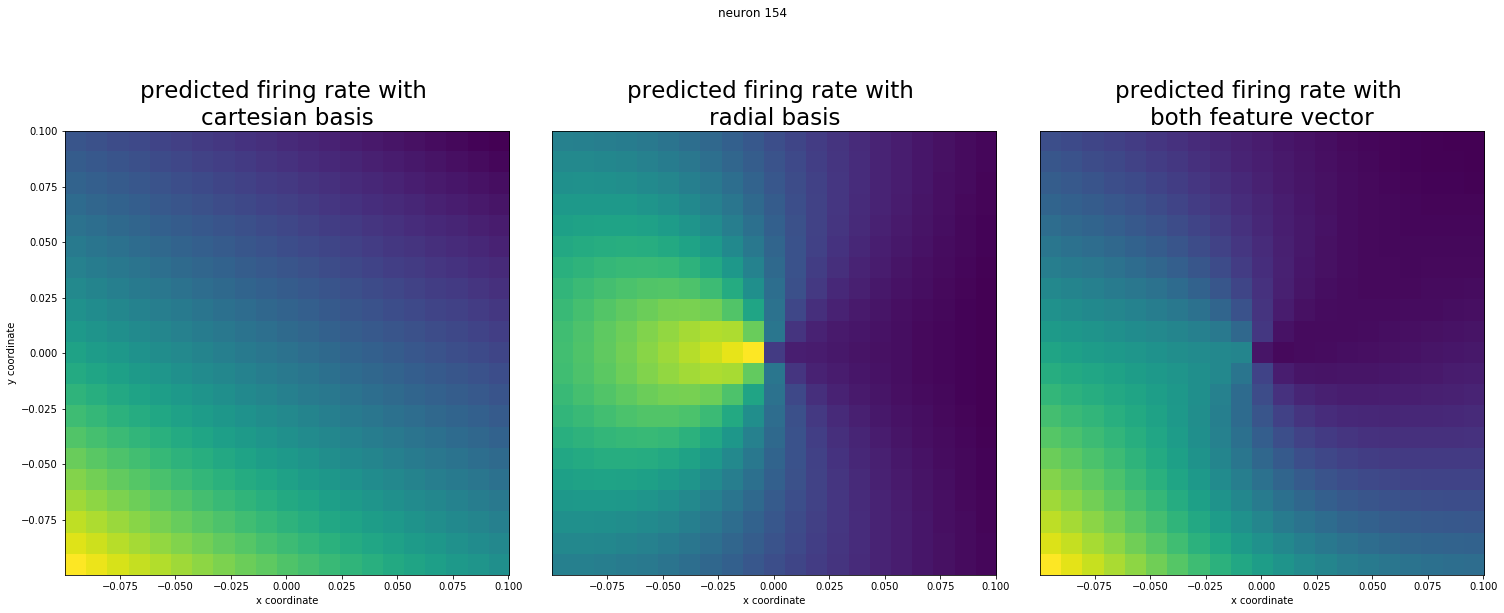

In [16]:
for i, ind in enumerate(best_neurons):
    poisson_model_cart, results_cart, rate_pred_cart, data_cart = \
    run_model(best_neurons[i], X, Y_cart, Y_cart_dummy, xx_cart_coord)


    poisson_model_radial, results_radial, rate_pred_radial, data_radial = \
    run_model(best_neurons[i], X, Y_rad, Y_rad_dummy, xx_cart_coord)

    poisson_model_comb, results_comb, rate_pred_comb, data_comb = \
    run_model(best_neurons[i], X, Y_comb, Y_comb_dummy, xx_cart_coord)
    title = 'neuron ' + str(ind)
    plot_predictions(rate_pred_cart,rate_pred_radial,rate_pred_comb, xx_cart_coord, title)

In [52]:
#sample from the inferred distribution
x_hat = results_cart.mu
samples = np.random.poisson(x_hat)

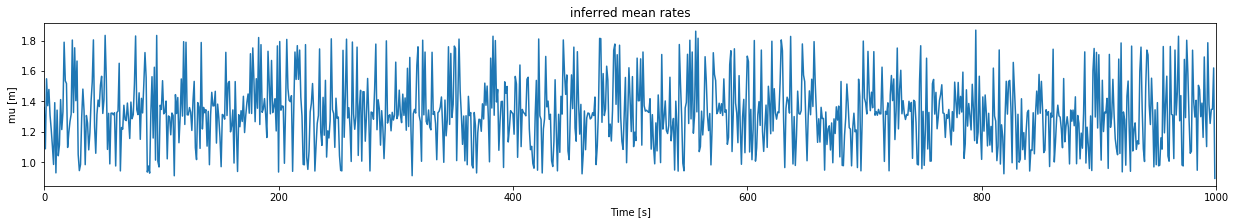

In [20]:
fig = plt.figure(figsize = (21, 3))
title = 'inferred mean rates'
plt.title(title)
minmax = (0, 1000)
plt.plot(x_hat[minmax[0]:minmax[1]])
plt.xlabel('Time [s]')
plt.ylabel('mu [m]')
plt.xlim([minmax[0],minmax[1]])
plt.show()

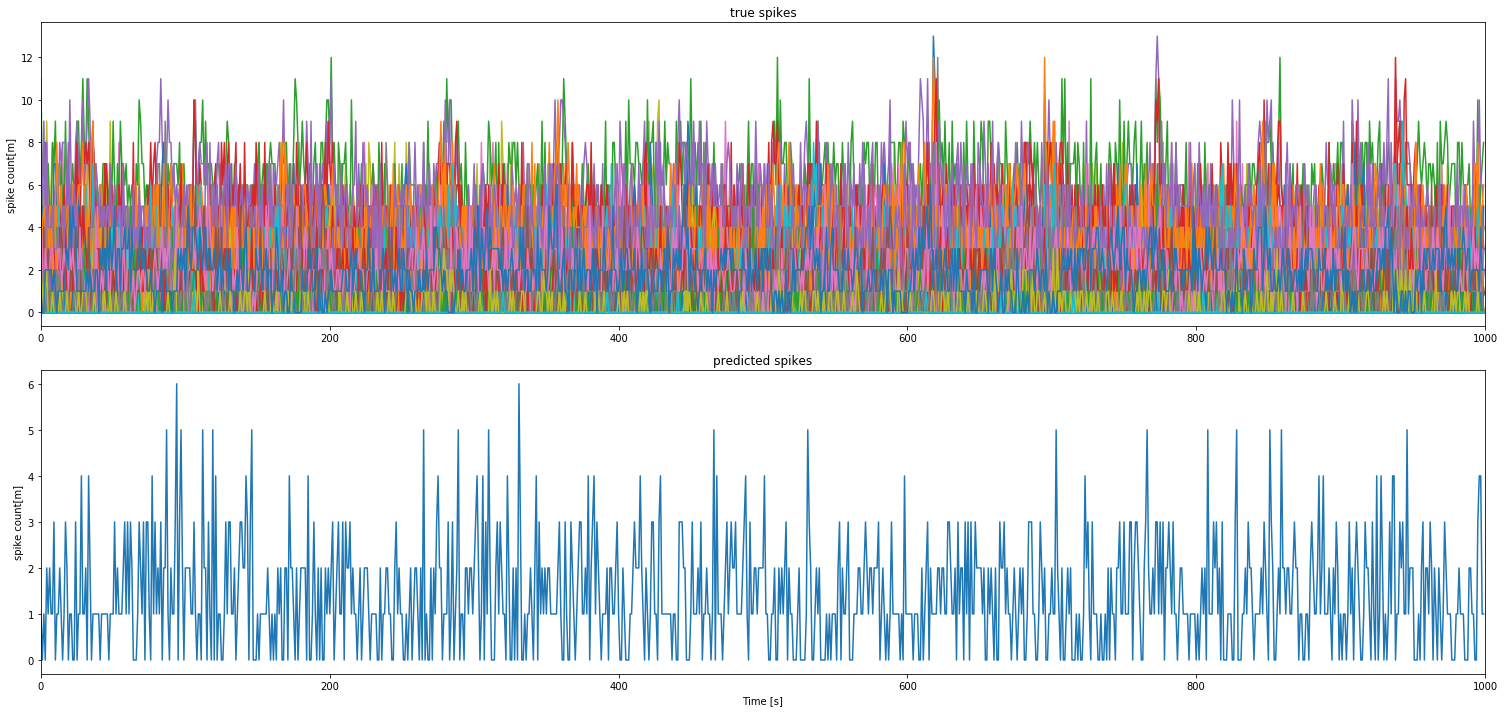

In [21]:
# sample from the inferred distribution 
fig = plt.figure(figsize = (21, 10))
title = 'inferred mean rates'
minmax = (0, 1000)
fig.add_subplot(2,1,1)
plt.plot(X_test[minmax[0]:minmax[1]])
# plt.xlabel('Time [s]')
plt.title('true spikes')
plt.ylabel('spike count[m]')
plt.xlim([minmax[0],minmax[1]])
fig.add_subplot(2,1,2)
plt.plot(samples[minmax[0]:minmax[1]])
plt.xlabel('Time [s]')
plt.title('predicted spikes')
plt.ylabel('spike count[m]')
plt.xlim([minmax[0],minmax[1]])
plt.tight_layout()